In [10]:
%cd /content
!unzip -qq "/content/data.zip"

/content


In [1]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-v2i53u2g/kobert-tokenizer_845f89b3507e44ee8784dd6cf5f4aa7e
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-v2i53u2g/kobert-tokenizer_845f89b3507e44ee8784dd6cf5f4aa7e
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4649 sha256=4788bf0f253db5d3088a0cf0714bd6258f5be70dc80a95123dd2e407995f00d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2d1fzc3/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-c68sd430
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-bui

## 1. 사용할 패키지 불러오기

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd 
import os


from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

## 2. GPU 환경 세팅

In [4]:
if torch.cuda.is_available():
    print("{} GPU를 사용합니다.".format(torch.cuda.get_device_name(0)))
    device = torch.device("cuda:0")
else: 
    print("GPU 사용이 불가능합니다.")
    device = torch.device("cpu")

Tesla T4 GPU를 사용합니다.


## 3. Pretrained 된 KoBERT 모델 불러오기.

In [6]:
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


## 4. 데이터 불러오기

### (1) 데이터셋 경로 정의

In [11]:
train_data_path = './data/train.xlsx'
test_data_path = './data/test.xlsx'

label_col = '주제'
text_col = '텍스트'

### (2) 데이터 불러오기

In [12]:
dataset_train = pd.read_excel(train_data_path)
dataset_test = pd.read_excel(test_data_path)

### (3) Label Encoding

In [14]:
le = LabelEncoder()
le = le.fit(dataset_train[label_col])
dataset_train[label_col] = le.transform(dataset_train[label_col])
dataset_test[label_col] = le.transform(dataset_test[label_col])
print("Label list: {}".format(le.classes_))

Label list: ['기쁨' '당황' '분노' '불안' '슬픔']


### (4) Text와 Label 분리하기

In [15]:
train_text = list(dataset_train[text_col])
train_label = list(dataset_train[label_col])
test_text = list(dataset_test[text_col])
test_label = list(dataset_test[label_col])

In [22]:
dataset_train = [[train_text[i], str(train_label[i])] for i in range(len(train_label))]
dataset_test = [[test_text[i], str(test_label[i])] for i in range(len(test_label))]

## 5. Hyper parameter Setting

In [20]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

## 6. Test Tokenize, Dataloader 생성

### (1) BERT Tokenizer 생성

In [18]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


### (2) Bert Dataloader 생성

In [19]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [23]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 7. 본 데이터에 맞는 Bert Model 생성

In [27]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=8,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out) 

model = BERTClassifier(bertmodel, num_classes = len(le.classes_), dr_rate=0.5).to(device)

## 8. Optimizer, Loss 정의

In [28]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

## 9. 평가 Metric 정의

In [29]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

## 10. Train

In [30]:
os.makedirs('./best_model', exist_ok = True)
save_best_model = './best_model/best_model.pt'
best_accuracy = 0

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    if test_acc > best_accuracy:
        print("Best model saved. Validation Acc: {} -> {}".format(best_accuracy, test_acc / (batch_id+1))) 
        best_accuracy = test_acc / (batch_id+1)
        torch.save(model, save_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 train acc 0.34375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 1 test acc 0.647265625
Best model saved. Validation Acc: 0 -> 10.35625


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 2 train acc 0.678995253164557


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 2 test acc 0.845703125
Best model saved. Validation Acc: 10.35625 -> 13.53125


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 3 train acc 0.8144778481012658


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 3 test acc 0.921484375
Best model saved. Validation Acc: 13.53125 -> 14.74375


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 4 train acc 0.8971518987341772


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 4 test acc 0.9646484375
Best model saved. Validation Acc: 14.74375 -> 15.434375


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 5 train acc 0.9394778481012658


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 5 test acc 0.975
Best model saved. Validation Acc: 15.434375 -> 15.6


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 6 train acc 0.9643987341772152


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 6 test acc 0.9896484375
Best model saved. Validation Acc: 15.6 -> 15.834375


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 7 train acc 0.978243670886076


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 7 test acc 0.9931640625
Best model saved. Validation Acc: 15.834375 -> 15.890625


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 8 train acc 0.9875395569620253


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 8 test acc 0.9935546875
Best model saved. Validation Acc: 15.890625 -> 15.896875


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 9 train acc 0.9926819620253164


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 9 test acc 0.9951171875
Best model saved. Validation Acc: 15.896875 -> 15.921875


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 10 train acc 0.995253164556962


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 10 test acc 0.9951171875


## 11. Inference

### (1) Best Model 불러오기

In [32]:
model = torch.load(save_best_model)

### (2) Inference

In [34]:
model.eval()
gt_list = []
out_list = []
for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    out_list.append(max_indices.data.cpu().numpy())
    gt_list.append(label.cpu().numpy())

gt_list = np.hstack(gt_list)
out_list = np.hstack(out_list)
distribution = confusion_matrix(gt_list, out_list)

100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


### (3) Confusion Matrix

Text(0.5, 1.0, 'Test Confusion matrix')

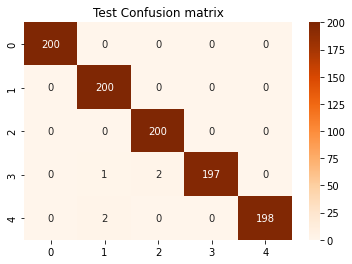

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
ax = sns.heatmap(distribution, annot=True, cmap='Oranges', fmt='g')
plt.title('Test Confusion matrix')